In [5]:
from numpy import *
from pandas import *
from matplotlib.pyplot import *
from seaborn import *
from os import *

In [15]:
bank = read_csv("bank.csv", delimiter = ";")
print(bank.shape)
print(path.getsize("bank.csv"))
bank.head()

(4521, 17)
461474


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [14]:
bank_full = read_csv("bank-full.csv", delimiter = ";")
print(bank_full.shape)
print(path.getsize("bank-full.csv"))
bank_full.head()

(45211, 17)
4610348


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


------

## Data Understanding

(Extracted from the bank-names.txt, section 7.)

Input variables:
   - bank client data:
       1. age (numeric)
       2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
       3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
       4. education (categorical: "unknown","secondary","primary","tertiary")
       5. default: has credit in default? (binary: "yes","no")
       6. balance: average yearly balance, in euros (numeric) 
       7. housing: has housing loan? (binary: "yes","no")
       8. loan: has personal loan? (binary: "yes","no")
   - related with the last contact of the current campaign:
       9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
       10. day: last contact day of the month (numeric)
       11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
       12. duration: last contact duration, in seconds (numeric)
   - other attributes:
       13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
       14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
       15. previous: number of contacts performed before this campaign and for this client (numeric)
       16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
   - Output variable (desired target):
       17. y - has the client subscribed a term deposit? (binary: "yes","no")

## Data Cleaning and Processing

1. Checking null and N/A values

In [13]:
print(bank_full.isnull().any())
print(bank_full.isna().any())

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool


No null or N/A values are presented

2. Checking outliers
    - First of all, select all columns with numeric values only (Focus on the smaller `bank` data first)

In [24]:
bank.skew(numeric_only=True)

age         0.699501
balance     6.596431
day         0.094627
duration    2.772420
campaign    4.743914
pdays       2.717071
previous    5.875259
dtype: float64

<AxesSubplot:xlabel='previous', ylabel='Count'>

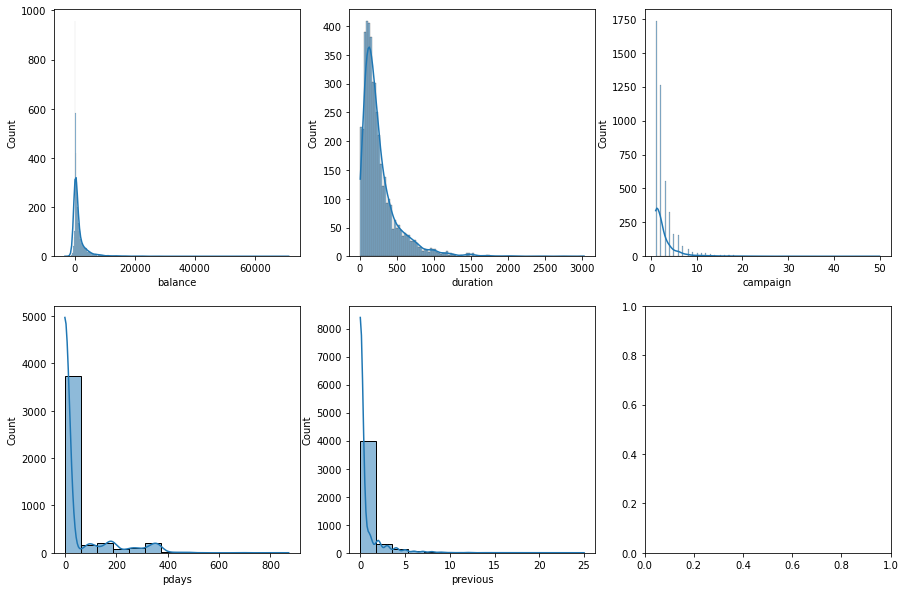

In [42]:
fig, axs = subplots(2,3, figsize=(15,10))
histplot(data = bank, x = "balance", kde = True, ax=axs[0,0])
histplot(data = bank, x = "duration", kde = True, ax=axs[0,1])
histplot(data = bank, x = "campaign", kde = True, ax=axs[0,2])
histplot(data = bank, x = "pdays", kde = True, ax=axs[1,0])
histplot(data = bank, x = "previous", kde = True, ax=axs[1,1])

The columns `balance`, `duration`, `campaign`, `pdays`, and `previous` are highly skewed to the right according to the table and plots. Therefore, perform log transformations on these columns.

<AxesSubplot:xlabel='logbalance', ylabel='Count'>

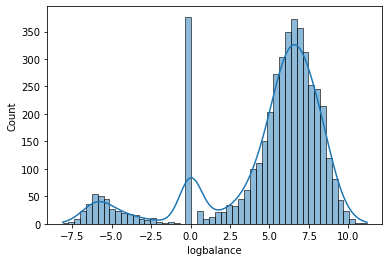

In [59]:
def reallog(x):
    if x < 0: return -log(-x)
    elif x == 0: return 0;
    else: return log(x)
bank["logbalance"] = bank['balance'].apply(reallog)
histplot(data = bank, x = "logbalance", kde = True)

Still highly skewed, perform another square root operation on it.

<AxesSubplot:xlabel='sqrtbalance', ylabel='Count'>

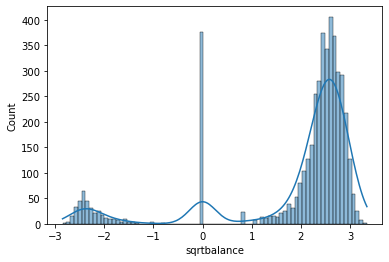

In [60]:
def realsqrt(x):
    if x < 0: return -sqrt(-x)
    else: return sqrt(x)
bank['sqrtbalance'] = bank['logbalance'].apply(realsqrt)
histplot(data = bank, x = "sqrtbalance", kde = True)

Perform similar log or square root transformations on other columns as well.

-0.5173183811595493


<AxesSubplot:xlabel='logduration', ylabel='Count'>

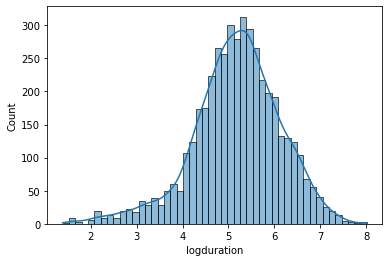

In [62]:
bank["logduration"] = bank['duration'].apply(reallog)
print(bank['logduration'].skew())
histplot(data = bank, x = "logduration", kde = True)

0.8709254966680438


<AxesSubplot:xlabel='logcampaign', ylabel='Count'>

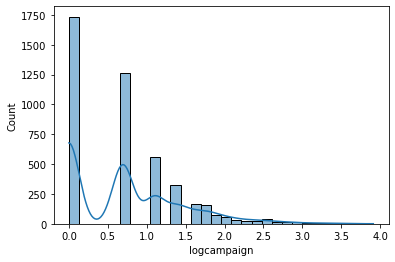

In [64]:
bank["logcampaign"] = bank['campaign'].apply(reallog)
print(bank['logcampaign'].skew())
histplot(data = bank, x = "logcampaign", kde = True)

1.731911306961672


<AxesSubplot:xlabel='logpdays', ylabel='Count'>

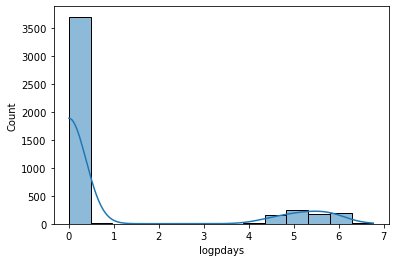

In [65]:
bank["logpdays"] = bank['pdays'].apply(reallog)
print(bank['logpdays'].skew())
histplot(data = bank, x = "logpdays", kde = True)

3.339249450238068


<AxesSubplot:xlabel='logprevious', ylabel='Count'>

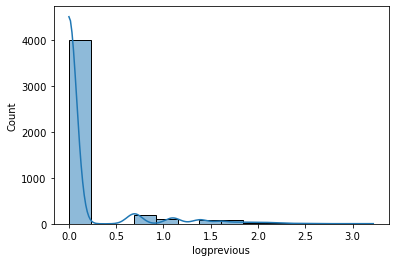

In [68]:
bank["logprevious"] = bank['previous'].apply(reallog)
print(bank['logprevious'].skew())
histplot(data = bank, x = "logprevious", kde = True)

As shown on the histograms, apart from bulk values of zero, the other values are not largely skewed.